# Chapter 2: Consensus Expected Returns, the CAPM

### Separating Returns

- The CAPM relies on two constructs: a market portfolio $M$ and beta $\beta$ which links the portfolio to the market.
- In theory $M$ contains all assets, but in practice we take it as a broad value-weighted index of traded domestic equities.

Suppose we have a portfolio $P$ with excess returns $r_{p}$ and the market portfolio $M$ with excess returns $r_{m}$. Then the beta of portfolio $P$ is equal to:

$$ \beta_{P} = \frac{\text{Cov}(r_{P},r_{M})}{\text{Var}(r_{M})} $$

The simplest estimate of $\beta_{P}$ comes from a linear regression of portfolio excess returns $r_{P}(t)$ on market excess returns $r_{M}(t)$ in the same period:

$$ r_{P}(t) = \alpha_{P} + \beta_{P}r_{M}(t) + \epsilon_{P}(t)  $$

These are realized or historical betas and alphas. These can be used for reasonable forecasts in the future, but evidence from Rosenberg (1985) suggests that betas tend to regress to the mean, so Bayesian analysis may be applicable here.

Beta is a way of separating risk and return into two parts : a market component and a residual component:


$$ r_{P} = \beta_{P}r_{M} + \theta_{P} $$


The residual return $\theta_{P}$ will be uncorrelated with the market return $r_{M}$ and so the variance of portfolio $P$ is:


$$ \sigma_{P}^{2} = \beta^{2}_{P}\sigma_{M}^{2} + \omega_{P}^{2} $$


Where $\omega_{P}^{2}$ is the residual variance of the portfolio.

The **CAPM** states that the expected residual return on all stocks and any portfolio is equal to zero, i.e. $E[\theta_{P}]=0$. Therefore, the expected excess return on the portfolio $E[r_{P}]=\mu_{P}$ is determined entirely by the expected excess return on the market, $E[r_{M}]=\mu_{M}$ and the portfolio $\beta$, i.e:

$$ E[r_{P}] = \beta_{P}E[r_{M}] =  \beta_{P}\mu_{M} $$

#### Python Example

We will use the S&P500 as 'the market', Macy's (**M**) as an example stock, and the 1-month Treasury bill as the risk-free rate (we convert the rate to daily returns). First we load libraries:

First we will load data on the S&P500 (the market) for the period 2011-2014. We'll use data for the SPY ETF:

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import DataReader
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline 

First we load data on the risk-free rate and convert to daily returns:

In [2]:
START="2012-01-01"
END="2015-01-01"
START_EX_POST="2015-01-02"
END_EX_POST="2016-01-01"

one_mon = DataReader('DGS1MO', 'fred',datetime(2012,1,1), datetime(2015,1,1))
one_day = np.log(1+one_mon)/365

Next we load details on S&P500 returns:

Text(0.5, 1.0, 'S&P500 Returns')

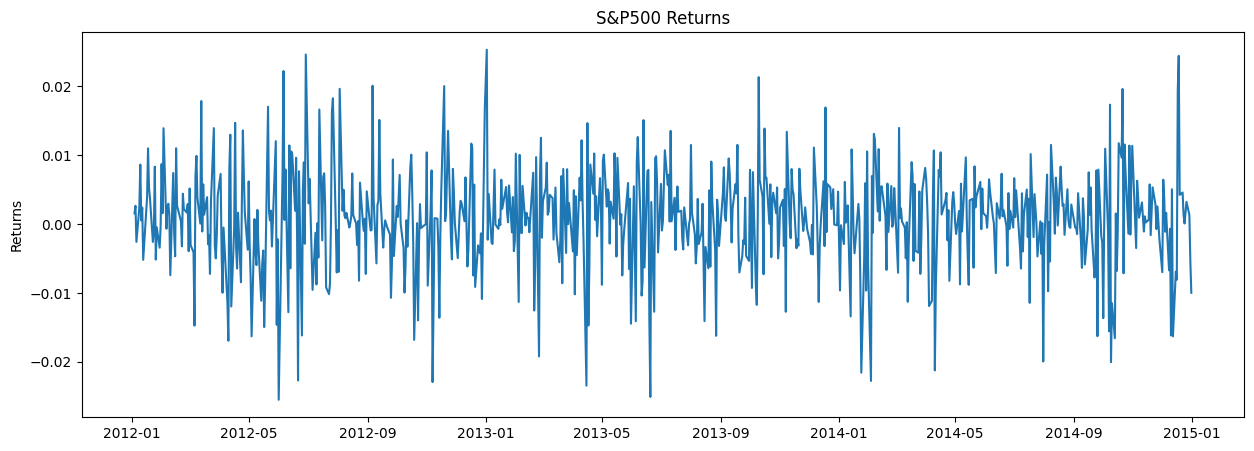

In [3]:
spy = yf.download("SPY", start=START, end=END, progress=False)
close_prices = np.ravel(spy['Close'].values)
spy_returns = pd.DataFrame(np.diff(np.log(close_prices)))

spy_returns.index = spy.index.values[1:spy.index.values.shape[0]]
spy_returns.columns = ['S&P500 Returns']

plt.figure(figsize=(15,5))
plt.plot(spy_returns)
plt.ylabel('Returns')
plt.title('S&P500 Returns')

We'll calculate returns an example stock that's listed on this index - for example, Macy's (**M**):

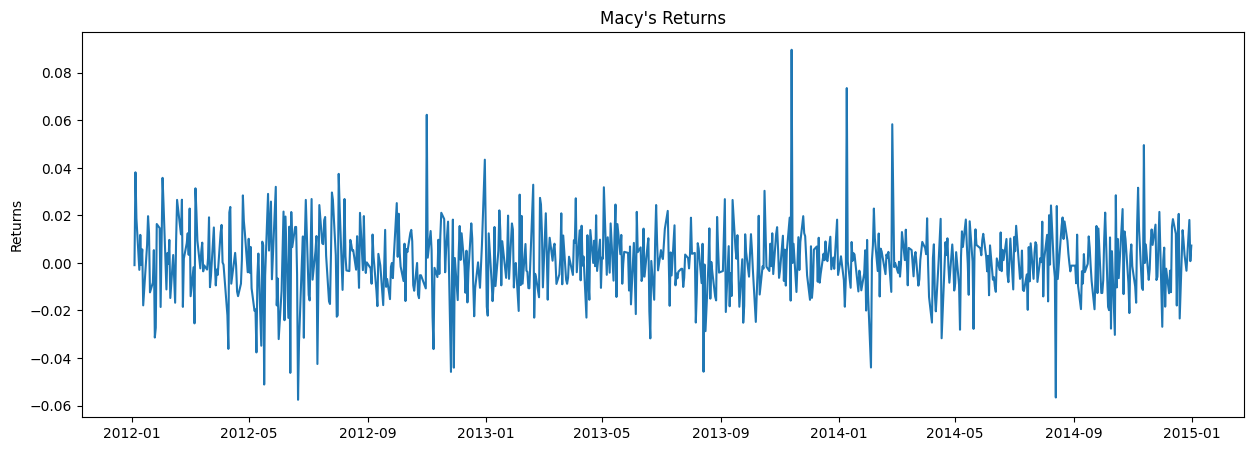

In [4]:
m = yf.download("M", start=START, end=END, progress=False)
m_returns = pd.DataFrame(np.diff(np.log(m['Close'].values.ravel())))
m_returns.index = spy.index.values[1:m.index.values.shape[0]]
m_returns.columns = ["Macy's Returns"]

plt.figure(figsize=(15,5))
plt.plot(m_returns)
plt.ylabel('Returns')
plt.title("Macy's Returns")
plt.show()

Next we need to merge the series to make sure they are all on the same timescale and then calculate the excess returns:

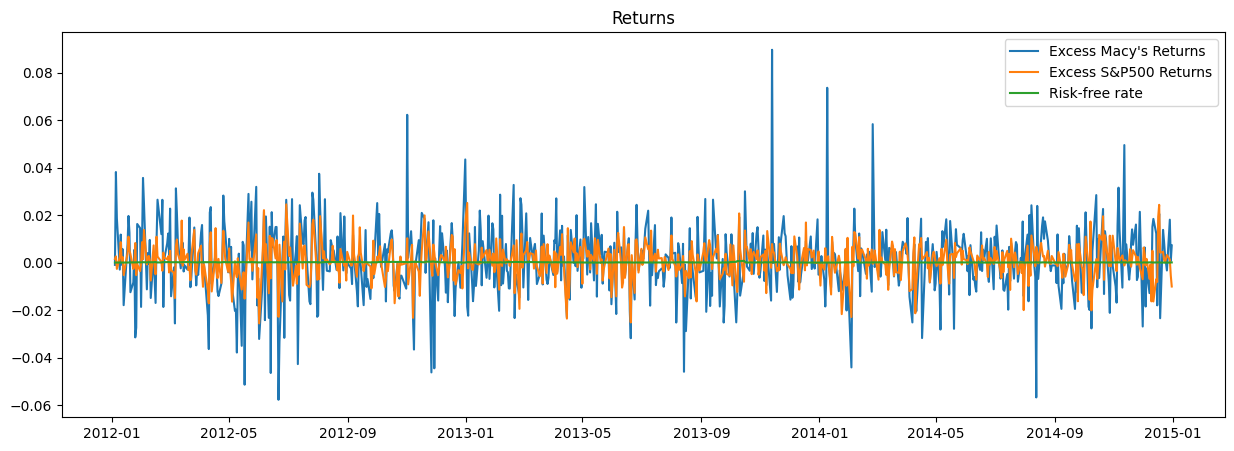

In [5]:
returns = pd.concat([one_day,m_returns,spy_returns],axis=1).dropna()
excess_m = returns["Macy's Returns"].values - returns['DGS1MO'].values
excess_spy = returns["S&P500 Returns"].values - returns['DGS1MO'].values
final_returns = pd.DataFrame(np.transpose([excess_m,excess_spy, returns['DGS1MO'].values]))
final_returns.columns=["Excess Macy's Returns","Excess S&P500 Returns","Risk-free rate"]
final_returns.index = returns.index

plt.figure(figsize=(15,5))
plt.title("Returns")
handles = plt.plot(final_returns)
plt.legend(handles=handles, labels=list(final_returns.columns))
plt.show()

Now we will perform a linear regression using the two series:

In [6]:
exog = excess_spy
exog = sm.add_constant(exog, prepend=True)
mod = sm.OLS(excess_m, exog)
res = mod.fit()
print(res.summary())
alpha_m = res.params[0]
beta_m = res.params[1]
print()
print(f'Macys: Beta: {beta_m:.4f}, Alpha: {alpha_m:.4f}')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     248.1
Date:                Wed, 15 Jan 2025   Prob (F-statistic):           1.81e-48
Time:                        20:39:29   Log-Likelihood:                 2175.6
No. Observations:                 747   AIC:                            -4347.
Df Residuals:                     745   BIC:                            -4338.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.637      0.5

From this $\beta_{M}=1.032$ and $\alpha=+0.0003$, although the latter is not statistically significant - this is consistent with CAPM which predicts no excess expected residual returns.

Using these results we can split the excess returns into the market component and residual component:

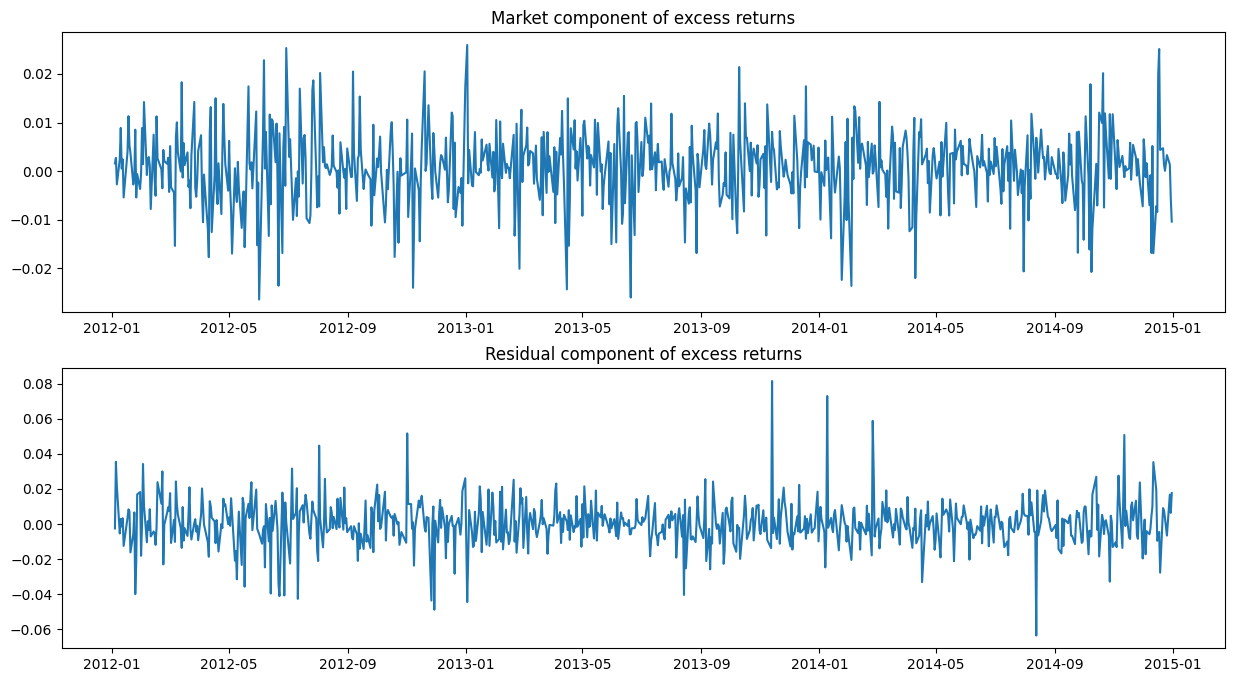

In [7]:
market_c = excess_spy*beta_m
residual_c = excess_m - market_c

plt.figure(figsize=(15,8))
plt.subplot(211)
plt.title("Market component of excess returns")
plt.plot(final_returns.index,market_c)
plt.subplot(212)
plt.title("Residual component of excess returns")
plt.plot(final_returns.index,residual_c)
plt.show()

### More on CAPM

The "sensible" implications of CAPM:

- Under CAPM, an individual whose portfolio differs from the market is playing a zero-sum game. They have additional risk with no additional expected return.
- CAPM taken literally implies that passive management is optimal. Residual risk is not what we would care about as it is self-imposed and avoidable.

Implications for portfolio management:

- Taking consensus expected returns from CAPM and plugging them into an optimizer yields the market portfolio.
- Alternatively we can take the market portfolio and assume it is optimal, and then back out the expected returns consistent with that assumption.

### Ex Post and Ex Ante CAPM

Let's expand the analysis to 2 more stocks **AMZN** and **RL** (Amazon and Ralph Lauren):

In [8]:
a = yf.download("AMZN", start=START, end=END, progress=False)
a_returns = pd.DataFrame(np.diff(np.log(a['Close'].values.ravel())))
a_returns.index = a.index.values[1:a.index.values.shape[0]]
a_returns.columns = ["Amazon Returns"]

ua = yf.download('RL', start=START, end=END, progress=False)
ua_returns = pd.DataFrame(np.diff(np.log(ua['Close'].values.ravel())))
ua_returns.index = ua.index.values[1:ua.index.values.shape[0]]
ua_returns.columns = ["RL Returns"]

returns = pd.concat([one_day,a_returns,ua_returns],axis=1).dropna()
excess_a = returns["Amazon Returns"].values - returns['DGS1MO'].values
excess_ua = returns["RL Returns"].values - returns['DGS1MO'].values

We need the betas from each:

In [9]:
mod = sm.OLS(excess_a, exog)
res = mod.fit()
alpha_amzn = res.params[0]
beta_amzn = res.params[1]
print(res.summary())

mod = sm.OLS(excess_ua, exog)
res = mod.fit()
alpha_rl = res.params[0]
beta_rl = res.params[1]
print(res.summary())
print()
print(f'Amazon: Beta: {beta_amzn:.4f}, Alpha: {alpha_amzn:.4f}')
print(f'Ralph Lauren: Beta: {beta_rl:.4f}, Alpha: {alpha_rl:.4f}')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     230.8
Date:                Wed, 15 Jan 2025   Prob (F-statistic):           1.32e-45
Time:                        20:39:30   Log-Likelihood:                 1994.4
No. Observations:                 747   AIC:                            -3985.
Df Residuals:                     745   BIC:                            -3976.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.317      0.7

Now let's form the expected annual returns for our three stocks and the market and plot the **security market line** ex ante:

Text(0, 0.5, 'Expected Annual Return')

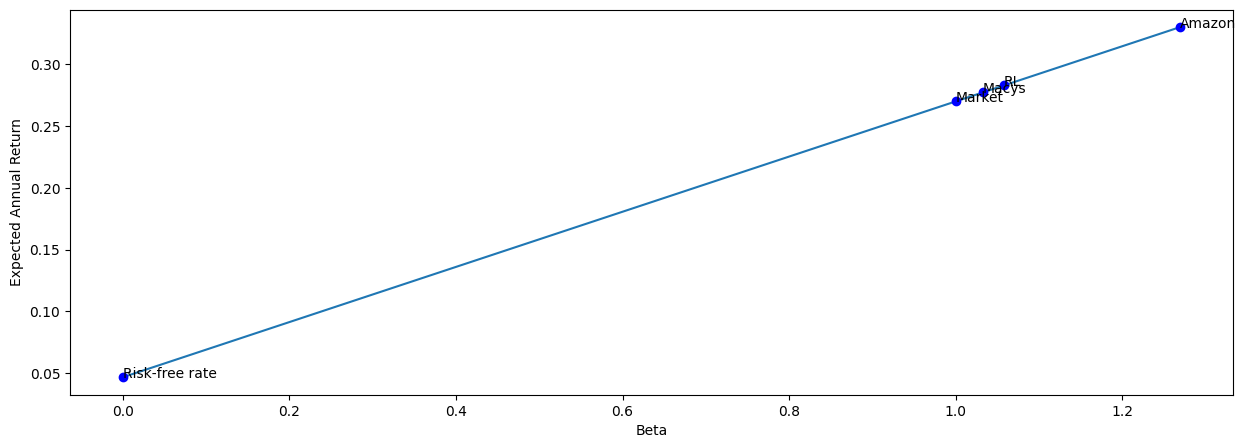

In [10]:
expected_spy = np.log(1+np.mean(excess_spy))*365
betas = np.array([0,1,beta_m,beta_rl, beta_amzn])
expected_rf = np.log(1+np.mean(returns['DGS1MO'].values))*365
expected_returns = betas*expected_spy + expected_rf
data_names = ['Risk-free rate', 'Market','Macys','RL','Amazon']

plt.figure(figsize=(15,5))
plt.plot(betas,expected_returns)
plt.plot(betas,expected_returns,'bo')

for i, txt in enumerate(expected_returns):
    plt.annotate(data_names[i], (betas[i],expected_returns[i]))

plt.xlabel("Beta")
plt.ylabel("Expected Annual Return")

Here the intercept is the risk-free rate, and the slope is equal to the expected excess return for the market. Now let's look at ex-post returns for the next year. We assume for simplicity that the betas and risk-free rate are the same:

In [11]:
a_new = yf.download("AMZN", start=START_EX_POST, end=END_EX_POST, progress=False)
a_new_price = a_new['Close'].values.ravel()
a_annual = (a_new_price[a_new_price.shape[0]-1]/a_new_price[0] - 1)

m_new = yf.download("M", start=START_EX_POST, end=END_EX_POST, progress=False)
m_new_price = m_new['Close'].values.ravel()
m_annual = (m_new_price[m_new_price.shape[0]-1]/m_new_price[0] - 1)

ua_new = yf.download("RL", start=START_EX_POST, end=END_EX_POST, progress=False)
ua_new_price = ua_new['Close'].values.ravel()
ua_annual = (ua_new_price[ua_new_price.shape[0]-1]/ua_new_price[0] - 1)

spy_new = yf.download("SPY", start=START_EX_POST, end=END_EX_POST, progress=False)
spy_new_price = spy_new['Close'].values.ravel()
spy_annual = (spy_new_price[spy_new_price.shape[0]-1]/spy_new_price[0] - 1)

expected_returns_real = [expected_returns[0],spy_annual,m_annual,ua_annual,a_annual]
sml_real = np.array([0,1,beta_m,beta_rl, beta_amzn])*spy_annual
sml_real[0] = expected_returns[0]

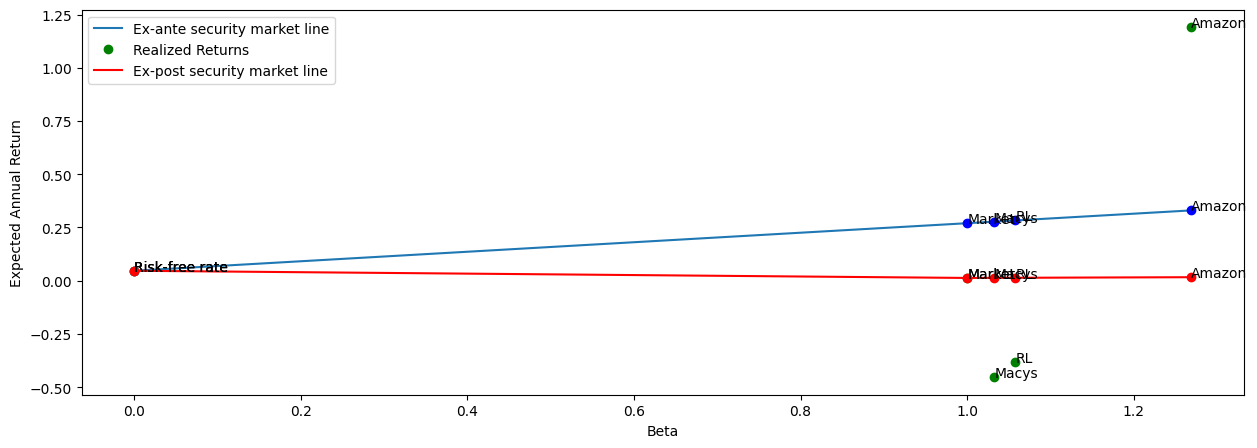

In [12]:
plt.figure(figsize=(15,5))

plt.plot(betas,expected_returns,label='Ex-ante security market line')
plt.plot(betas,expected_returns,'bo')
plt.plot(betas,expected_returns_real,'go', label='Realized Returns')

plt.plot(betas,sml_real,c='r',label='Ex-post security market line')
plt.plot(betas,sml_real,'ro')

for i, txt in enumerate(expected_returns):
    plt.annotate(data_names[i], (betas[i],expected_returns[i]))
  
for i, txt in enumerate(expected_returns):
    plt.annotate(data_names[i], (betas[i],sml_real[i]))    
    
for i, txt in enumerate(expected_returns):
    plt.annotate(data_names[i], (betas[i],expected_returns_real[i]))
    
plt.xlabel("Beta")
plt.ylabel("Expected Annual Return")
plt.legend(loc=2)
plt.show()

Here the ex-post SML tells us the component of return that CAPM would have forecast if we had known how the market portfolio was going to perform. The slope is negative since the market returned less than the risk-free rate in this period.

Another way to visualize CAPM is by plotting daily excess returns from a stock and the market. Here we plot excess returns for Amazon against the S&P500 for the period 2012-2014:

Text(0.5, 0, 'Amazon Excess Returns')

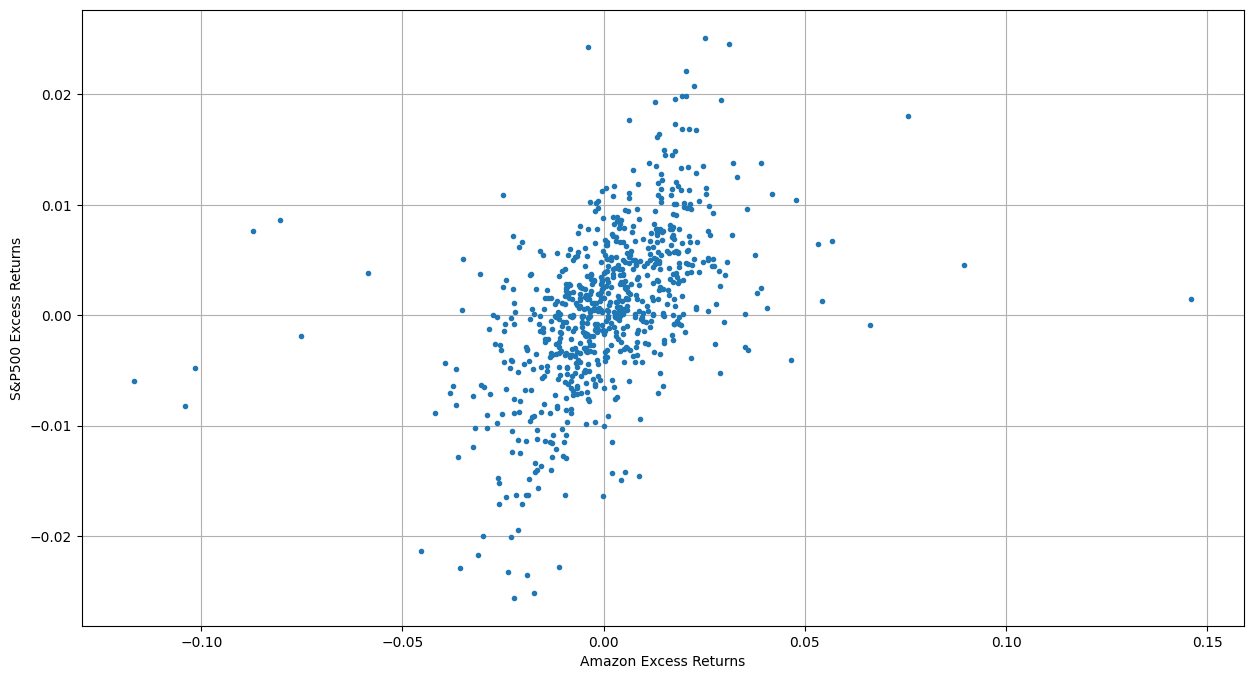

In [13]:
plt.figure(figsize=(15,8))
plt.plot(excess_a,excess_spy,'.')
plt.grid(True)
plt.ylabel("S&P500 Excess Returns")
plt.xlabel("Amazon Excess Returns")

### CAPM and Relevance for Active Managers

CAPM works well compared to the naive hypothesis that the expected returns on all stocks are the same, but less well when we test the hypothesis that $\alpha$ is 0. As for relevance for active managers, on the surface CAPM looks not particularly useful given its implications, but it is still useful as a benchmark by which to evaluate value-added by the active manager. 

CAPM can also help an active manager distinguish between market and residual components of return. This decomposition can help managers avoid taking active market positions by allowing them to take portfolio betas closer to 1 (i.e. it allows them to avoid the risk of market timing and to focus research on residual returns that have a consensus expectation of zero).

### CAPM and Forecasting

- Need to have forecasts of betas! Simplest is historical measure; more advanced: state space modelling.
- Need to have forecasts of expected excess market returns! Same options as above.